In [1]:
import time 
import multiprocessing as mp
from multiprocessing import Pool
from collections import defaultdict
import sys
sys.path.append('/home/ak/Documents/PaperCode/stylised_facts')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import lob_for_futures as lobFut
from lob_for_futures import *

from scipy.stats import jarque_bera
import matplotlib.pyplot as plt

from dateutil.parser import parse
from pandas.tseries.offsets import BDay
import pickle as pkl
import fnmatch
import pickle
import datetime as dt
from datetime import timedelta
import glob
import fathon
from fathon import fathonUtils as fu
import itertools
import pyinform as pyinf
# import pingouin as pig
import seaborn as sns
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
from scipy.special import kl_div
import time
import pickle as pkl
import matplotlib.ticker as mtick

from functools import partial

def returns(s):

    # compute log returns
    arr = np.diff(np.log(s))

    return (pd.Series(arr, index=s.index[1:]))

In [2]:
# Lets create a function that shifted your dataframe first before calling the corr(). 
# Let us break down what we hope to accomplish, and then translate that into code. 
# For each hour (row) and for a given feature (column) I would like to find the value 
# for that feature N hours prior. 
# For each value of N (1-6 in our case) I want to make a new column 
# for that feature representing the Nth prior hour's measurement.

def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1)
    return df

def get_test_stats(bar_types,bar_returns,test_func,*args,**kwds):
    
    dct = {bar:(int(bar_ret.shape[0]), test_func(bar_ret,*args,**kwds)) 
           for bar,bar_ret in zip(bar_types,bar_returns)}
    df = (pd.DataFrame.from_dict(dct)
          .rename(index={0:'sample_size',1:f'{test_func.__name__}_stat'})
          .T)
    return df

In [11]:
loc_activityClockData = '/media/ak/My Passport/ActivityClockData'
loc_ProcessedDataForExperiments = '/media/ak/My Passport1/ExperimentData/ProcessedDataForExperiments'
list_activityClockData = os.listdir('/media/ak/My Passport1/ActivityClockData')

os_data = '/media/ak/OS/Data'
FuturesDataSemiProcessed = os.path.join(os_data, 'FuturesDataSemiProcessed')
bars = ['tick', 'volume', 'calendar', 'dollar']

In [12]:
symbols = os.listdir(FuturesDataSemiProcessed)
jb1_data_loc = os.path.join(FuturesDataSemiProcessed, 'JB1')
symbol_data_list = sorted(os.listdir(jb1_data_loc))
symbol_data_dates = [f.split('.')[0] for f in symbol_data_list if str('.pkl') in f]

In [13]:
file_idx = 0
file_loc = os.path.join(jb1_data_loc, symbol_data_list[file_idx])
pickled_default_dict = pd.read_pickle(file_loc)
date = list(pickled_default_dict.keys())


In [14]:
loaded_pickle_file = pd.read_pickle(file_loc)

In [15]:
keys = list(loaded_pickle_file.keys())
print(keys)

['20180416']


In [16]:
all_dfs = loaded_pickle_file[keys[0]]
all_dfs.keys()

dict_keys(['tick', 'volume', 'calendar', 'dollar'])

In [17]:
tick_df = all_dfs['tick']
volume_df = all_dfs['volume']
calendar_df = all_dfs['calendar']
dollar_df = all_dfs['dollar']

In [28]:
dollar_df.columns.values # do cross correlation here

array(['BidSize_open', 'BidSize_high', 'BidSize_low', 'BidSize_close',
       'QuoteTime_open', 'QuoteTime_high', 'QuoteTime_low',
       'QuoteTime_close', 'type_x_open', 'type_x_high', 'type_x_low',
       'type_x_close', 'BestBid_open', 'BestBid_high', 'BestBid_low',
       'BestBid_close', 'TradeTime_open', 'TradeTime_high',
       'TradeTime_low', 'TradeTime_close', 'AskSize_open', 'AskSize_high',
       'AskSize_low', 'AskSize_close', 'time_y_open', 'time_y_high',
       'time_y_low', 'time_y_close', 'type_y_open', 'type_y_high',
       'type_y_low', 'type_y_close', 'BestAsk_open', 'BestAsk_high',
       'BestAsk_low', 'BestAsk_close', 'TradeSize_open', 'TradeSize_high',
       'TradeSize_low', 'TradeSize_close', 'type_open', 'type_high',
       'type_low', 'type_close', 'TradePrice_open', 'TradePrice_high',
       'TradePrice_low', 'TradePrice_close', 'TimeStamp_open',
       'TimeStamp_high', 'TimeStamp_low', 'TimeStamp_close',
       'TradeVolume_open', 'TradeVolume_high', 'Tr

In [18]:
volume_df_micro_structure = lobFut.apply_micro_structure_features(volume_df)

Applying micro-structure features


In [35]:
volume_df_micro_structure

,volume_bucket,BidSize_open,BidSize_high,BidSize_low,BidSize_close,QuoteTime_open,QuoteTime_high,QuoteTime_low,QuoteTime_close,type_x_open,type_x_high,type_x_low,type_x_close,BestBid_open,BestBid_high,BestBid_low,BestBid_close,TradeTime_open,TradeTime_high,TradeTime_low,TradeTime_close,AskSize_open,AskSize_high,AskSize_low,AskSize_close,time_y_open,time_y_high,time_y_low,time_y_close,type_y_open,type_y_high,type_y_low,type_y_close,BestAsk_open,BestAsk_high,BestAsk_low,BestAsk_close,TradeSize_open,TradeSize_high,TradeSize_low,TradeSize_close,TradePrice_open,TradePrice_high,TradePrice_low,TradePrice_close,TimeStamp_open,TimeStamp_high,TimeStamp_low,TimeStamp_close,TradeVolume_open,TradeVolume_high,TradeVolume_low,TradeVolume_close,total_traded_volume_open,total_traded_volume_high,total_traded_volume_low,total_traded_volume_close,milliSeconds_open,milliSeconds_high,milliSeconds_low,milliSeconds_close,dollar_traded_volume_open,dollar_traded_volume_high,dollar_traded_volume_low,dollar_traded_volume_close,timeStampIdx_open,timeStampIdx_high,timeStampIdx_low,timeStampIdx_close,micro_price_open,micro_price_high,micro_price_low,micro_price_close,type_open,type_high,type_low,type_close,weighted_average_BestBid,weighted_average_BestAsk,weighted_activity_spread,total_size,micro_price,price_imbalance,pct_change_micro_price,simple_mid_price
0,1.0,342,342,22,342,2018-09-27 00:00:46,2018-09-27 00:00:47,2018-09-27 00:00:46,2018-09-27 00:00:47,BID,BID,BID,BID,150.17,150.18,150.17,150.17,2018-09-27 00:00:46,2018-09-27 00:00:47,2018-09-27 00:00:46,2018-09-27 00:00:47,214,214,49,49,2018-09-27 00:00:46,2018-09-27 00:00:47,2018-09-27 00:00:46,2018-09-27 00:00:47,ASK,ASK,ASK,ASK,150.19,150.19,150.18,150.18,19.0,19.0,9.0,9.0,150.18,150.18,150.18,150.18,00:00:46,00:00:47,00:00:46,00:00:47,19.0,19.0,9.0,9.0,19.0,19.0,9.0,9.0,46000,47000,46000,47000,2853.42,2853.42,1351.62,1351.62,2018-09-27 00:00:46,2018-09-27 00:00:47,2018-09-27 00:00:46,2018-09-27 00:00:47,150.177698,150.189068,150.171253,150.171253,NaN,NaN,NaN,NaN,150.173263,150.188137,0.014874,1574,150.178234,-49.798361,NaN,150.179140
1,2.0,342,342,8,335,2018-09-27 00:00:47,2018-09-27 00:00:51,2018-09-27 00:00:47,2018-09-27 00:00:51,BID,BID,BID,BID,150.17,150.18,150.17,150.17,2018-09-27 00:00:47,2018-09-27 00:00:51,2018-09-27 00:00:47,2018-09-27 00:00:51,49,221,49,75,2018-09-27 00:00:47,2018-09-27 00:00:51,2018-09-27 00:00:47,2018-09-27 00:00:51,ASK,ASK,ASK,ASK,150.18,150.19,150.18,150.18,9.0,49.0,8.0,8.0,150.18,150.18,150.18,150.18,00:00:47,00:00:51,00:00:47,00:00:51,9.0,49.0,8.0,8.0,9.0,49.0,8.0,8.0,47000,51000,47000,51000,1351.62,7358.82,1201.44,1201.44,2018-09-27 00:00:47,2018-09-27 00:00:51,2018-09-27 00:00:47,2018-09-27 00:00:51,150.171253,150.189651,150.171253,150.171829,NaN,NaN,NaN,NaN,150.173330,150.185609,0.012279,1421,150.176735,-66.892949,3.836096e-06,150.177894
2,3.0,314,335,309,322,2018-09-27 00:00:51,2018-09-27 00:00:54,2018-09-27 00:00:51,2018-09-27 00:00:54,BID,BID,BID,BID,150.17,150.17,150.17,150.17,2018-09-27 00:00:51,2018-09-27 00:00:54,2018-09-27 00:00:51,2018-09-27 00:00:54,75,81,75,81,2018-09-27 00:00:51,2018-09-27 00:00:54,2018-09-27 00:00:51,2018-09-27 00:00:54,ASK,ASK,ASK,ASK,150.18,150.18,150.18,150.18,8.0,10.0,8.0,10.0,150.18,150.18,150.18,150.18,00:00:51,00:00:54,00:00:51,00:00:54,8.0,10.0,8.0,10.0,8.0,10.0,8.0,10.0,51000,54000,51000,54000,1201.44,1501.80,1201.44,1501.80,2018-09-27 00:00:51,2018-09-27 00:00:54,2018-09-27 00:00:51,2018-09-27 00:00:54,150.171928,150.172057,150.171829,150.172010,NaN,NaN,NaN,NaN,150.170000,150.180000,0.010000,1592,150.171960,-91.307437,1.203004e-06,150.175000
3,4.0,323,326,285,287,2018-09-27 00:00:54,2018-09-27 00:01:03,2018-09-27 00:00:54,2018-09-27 00:01:03,BID,BID,BID,BID,150.17,150.17,150.17,150.17,2018-09-27 00:00:54,2018-09-27 00:01:03,2018-09-27 00:00:54,2018-09-27 00:01:03,81,113,81,113,2018-09-27 00:00:54,2018-09-27 00:01:03,2018-09-27 00:00:54,2018-09-27 00:01:03,ASK,ASK,ASK,ASK,150.18,150.18,150.18,150.18,10.0,10.0,10.0,10.0,150.1

In [23]:
volume_df_vol_estimation = lobFut.volatilityEstimation(volume_df)
tick_df_vol_estimation = lobFut.volatilityEstimation(tick_df)

(array([101., 258., 621., 673., 532., 232., 110.,  31.,   1.,  19.]),
 array([4.39643603e-05, 7.32228448e-05, 1.02481329e-04, 1.31739814e-04,
        1.60998298e-04, 1.90256783e-04, 2.19515268e-04, 2.48773752e-04,
        2.78032237e-04, 3.07290721e-04, 3.36549206e-04]),
 <BarContainer object of 10 artists>)

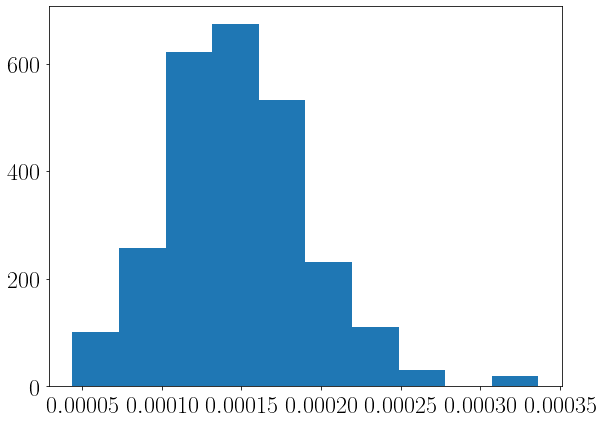

In [24]:
plt.hist(tick_df_vol_estimation.garmanKlass(5))

In [25]:
import seaborn as sns

<AxesSubplot:ylabel='Count'>

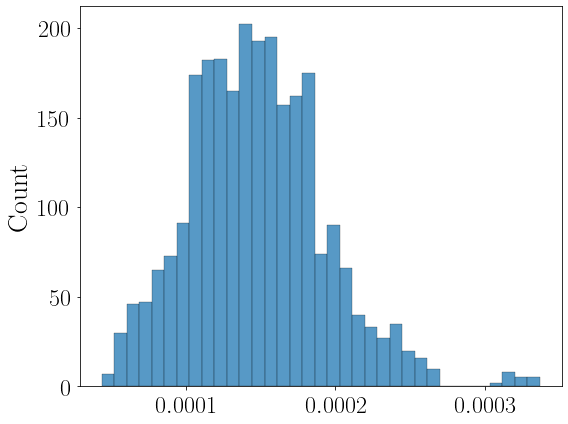

In [26]:
sns.histplot(tick_df_vol_estimation.garmanKlass(5))

In [36]:
experiments_results = '/media/ak/T7/June4th2022Experiments'

In [38]:
standard_returns_files = [f for f in os.listdir(experiments_results) if str('returns') in f]

In [40]:
symbol ='DU1'
symbol_standard_returns_files =[f for f in standard_returns_files if str(symbol) in f]

In [57]:
fileIdx = 1
file_loc = os.path.join(experiments_results, symbol_standard_returns_files[fileIdx])

In [58]:
lobFut.open_pickle_filepath(file_loc)['volume']

{1: volume_bucket
 50.0       -0.001223
 67.0       -0.034204
 84.0       -0.096343
 100.0       0.775518
 117.0       0.019516
               ...   
 362327.0   -0.439982
 362342.0   -0.064730
 362357.0   -0.116264
 362366.0   -0.313538
 362375.0    1.873759
 Length: 15456, dtype: float64}